A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [120]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import xgboost as xgb



# Import any additional modules and start coding below
df = pd.read_csv('rental_info.csv')

# to calculate rental length days, change datatype to datetime format
df['rental_date'] = pd.to_datetime(df['rental_date'])
df['return_date'] = pd.to_datetime(df['return_date'])

# calculate date diff
df['rental_length_days'] = (df['return_date'] - df['rental_date']).dt.days

# adding dummy variables using special features column
df['deleted_scenes'] = np.where(df['special_features'].fillna('').str.contains("Deleted Scenes"),1,0)
df['behind_the_scenes'] = np.where(df['special_features'].fillna('').str.contains("Behind the Scenes"),1,0)

# Separate target data from df and drop redundant columns
X = df.drop(['special_features','rental_date','return_date','rental_length_days'], axis=1)
y = df['rental_length_days']

In [121]:
# split data into train and test data
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

# Performing feature selection
lasso = LassoCV(cv=5, random_state=42)  
lasso.fit(X_train, y_train)
selected_features = X_train.columns[lasso.coef_ != 0] 

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# LinearRegression
model = LinearRegression()
model.fit(X_train_selected,y_train)
y_pred = model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
print('lr_mse:',mse)

# RandomForestRegression
rf = RandomForestRegressor(random_state=9)
rf.fit(X_train_selected, y_train)
rf_pred = rf.predict(X_test_selected)
rf_mse = mean_squared_error(y_test, rf_pred)
print('rf_mse:', rf_mse)



lr_mse: 3.064468760922549
rf_mse: 2.2889073882823237


In [122]:
# GridSearchCV for RandomForestRegressor, which is the best result previous codes
param_grid = {
    'n_estimators' : [280,300,320],
    'max_depth': list(range(25,33,2)),
    'max_features': ['log2'],
    'min_samples_split': [4,5,6],
    'min_samples_leaf': [1,2,3,]
}

grid_search = RandomizedSearchCV(
    estimator= RandomForestRegressor(random_state= 42),
    param_distributions= param_grid, scoring = 'neg_mean_squared_error', cv =4, n_jobs=-1, n_iter= 50
)

grid_search.fit(X_train_selected, y_train)
print('Best score', grid_search.best_score_)
print('Best Parameters:', grid_search.best_params_)

best_model = grid_search.best_estimator_
test_pred = best_model.predict(X_test_selected)
test_mse = mean_squared_error(y_test, test_pred)
print('Test MSE:', test_mse)
r2 = r2_score(y_test, test_pred)
print('R² Score:', r2)

Best score -2.3922632903342835
Best Parameters: {'n_estimators': 280, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 25}
Test MSE: 2.2801898006235524
R² Score: 0.6680666062104506


memo

cross_val_scores = cross_val_score(
    best_model,                
    X_train_selected,           
    y_train,                   
    scoring='neg_mean_squared_error',  
    cv=5                        
)

mse_scores = -cross_val_scores
print('Cross-Validation MSE Scores:', mse_scores)

In [124]:
# XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_search_xgb.fit(X_train_selected, y_train)

print("Best Parameters:", grid_search_xgb.best_params_)
print("Best CV Score:", -grid_search_xgb.best_score_)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}
Best CV Score: 2.2504289286711425


In [126]:
best_model_xgb = grid_search_xgb.best_estimator_
test_pred_xgb = best_model_xgb.predict(X_test_selected)
test_mse_xgb = mean_squared_error(y_test, test_pred_xgb)
print('XGB Test MSE:', test_mse_xgb)
r2 = r2_score(y_test, test_pred_xgb)
print('XGB R² Score:', r2)

XGB Test MSE: 2.196753152968379
XGB R² Score: 0.680212676525116


In [127]:
# which factors influence strongly?
importances = best_model_xgb.feature_importances_
features = X_train_selected.columns
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

         Feature  Importance
0         amount    0.564583
3  rental_rate_2    0.411410
2       length_2    0.024007
1       amount_2    0.000000


Based on the result, 'The amount paid by the customer for renting the DVD' influence to the rental date

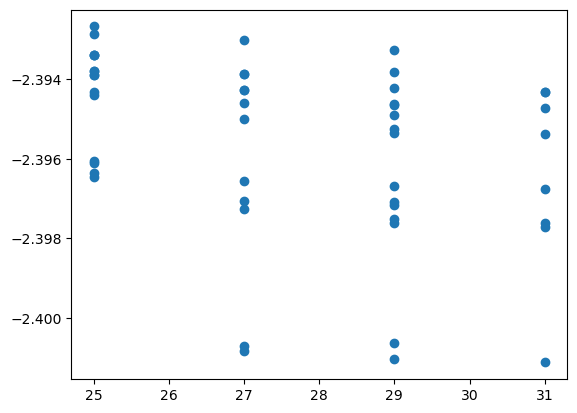

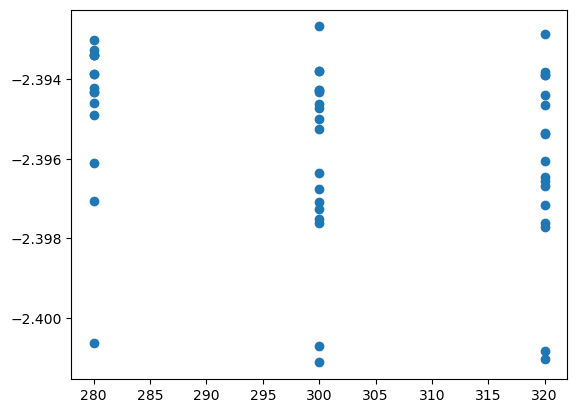

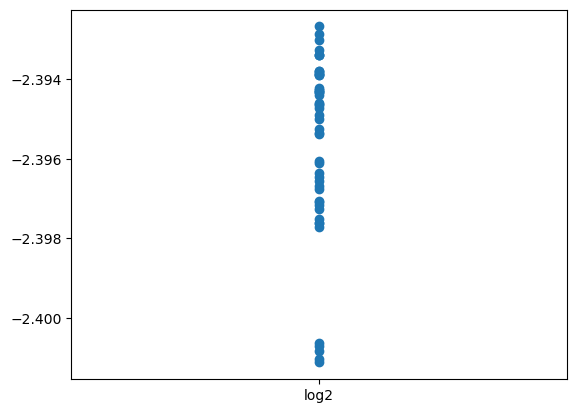

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)

plt.scatter(x = 'param_max_depth', y= 'mean_test_score', data=cv_results )
plt.show()

plt.scatter(x = 'param_n_estimators', y= 'mean_test_score', data=cv_results )
plt.show()

plt.scatter(x = 'param_max_features', y= 'mean_test_score', data=cv_results )
plt.show()
